In [ ]:
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from torch.autograd import Variable

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


I have data that has a new bias every datapoint. For example:

In [ ]:
def make_data(l=100, bias = 100):         
    return (torch.randn(l)*.1+ torch.arange(l) + torch.randn(1)*bias)[None,:]

In [ ]:
for i in [100, 200, 300]:
    x = make_data(l=11, bias = i)
    x, y= x[:,:9], x[:,-1]
    print(x,y)

tensor([[62.3799, 63.4259, 64.3857, 65.5097, 66.4785, 67.4576, 68.6136, 69.4785,
         70.4420]]) tensor([72.4677])
tensor([[-94.4864, -93.5647, -92.4024, -91.5976, -90.7541, -89.6858, -88.5592,
         -87.2961, -86.6319]]) tensor([-84.5226])
tensor([[540.6299, 541.7110, 542.7780, 543.7479, 544.9114, 545.7786, 546.7360,
         547.7943, 548.6898]]) tensor([550.7460])


This is a rather simple example but is I hope you understand the idea. 
It does not really help to normalize over the dataset/batch. For example:

In [ ]:
xb, yb = [], []
for i in [100, 200, 300]:
    x = make_data(l=11, bias = i)
    x, y= x[:,:9], x[:,-1]
    xb.append(x)
    yb.append(y)
xb, yb = torch.cat(xb), torch.cat(yb)
(xb-xb.mean())/xb.std(), (yb-xb.mean())/xb.std()

(tensor([[ 0.3367,  0.3413,  0.3461,  0.3512,  0.3544,  0.3603,  0.3642,  0.3699,
           0.3743],
         [ 0.9650,  0.9696,  0.9749,  0.9784,  0.9840,  0.9884,  0.9937,  0.9993,
           1.0025],
         [-1.3572, -1.3527, -1.3492, -1.3442, -1.3401, -1.3345, -1.3304, -1.3262,
          -1.3197]]), tensor([ 0.3828,  1.0130, -1.3115]))

It does help to do this per item: scale the input, run the model, and scale back to match the (should be) prediction. This really help the model to train better and there is no leakage since no y data is used to scale the prediction. 

I did this in `create_item`. For examle:

In [ ]:
xb, yb = [], []
for i in [100, 200, 300]:
    x = make_data(l=11, bias = i)
    x, y= x[:,:9], x[:,-1]
    xb.append((x-x.mean())/x.std())
    yb.append((y-x.mean())/x.std())
xb, yb = torch.cat(xb), torch.cat(yb)
(xb-xb.mean())/xb.std(), (yb-xb.mean())/xb.std()

(tensor([[-1.4768, -1.1911, -0.7628, -0.3886,  0.0444,  0.3560,  0.7571,  1.1187,
           1.5430],
         [-1.5020, -1.2109, -0.7504, -0.3387,  0.0050,  0.4018,  0.7681,  1.1345,
           1.4926],
         [-1.4600, -1.1334, -0.7901, -0.3764, -0.0726,  0.3756,  0.7257,  1.1631,
           1.5681]]), tensor([2.2095, 2.3414, 2.2393]))

Only this would not work well for predictions (in production or kaggle) because it is not part of encode/decode procces. This also means it does not show the data correcly (only normalized). So I do not really like that option.

I'm having some problem to implementing any other solution however. I first did this with a `ItemTransform` during `after_batch` only it assumes the last encoded is the one that needs to be decoded. 

In [ ]:
class NormalizeTS(ItemTransform):
    "Normalize the Time-Series."
    def __init__(self, verbose=False, make_ones=True, eps=1e-7, mean = None):
        """
        `make_ones` will make the std 1 if the std is smaller than `10*eps`. 
        This is for blok seqences to not magnify the `y` part of the data.
        
        `mean` will set a mean instead of the mean of the x value.
        """
        store_attr(self,'verbose, make_ones, eps, mean')
        self.m, self.s = 0, 0
        
    def encodes(self, o):         
        self.m, self.s = torch.mean(o[0],-1,keepdim=True), o[0].std(-1,keepdim=True) +self.eps
        if self.verbose:
            print('encodes',type(o),[a.shape for a in o], self.m,self.s) 
        if self.mean:
            self.m = o[0][self.mean]
        if self.make_ones:
            self.s[self.s < self.eps*10] = 1
            if self.verbose:
                print(o[0])
                print(f"made {self.s < self.eps*10} to ones due to setting `make_ones`")
                print(f"m:{self.m}\n s:{self.s}")
        return Tuple([(o[i]-self.m)/self.s for i in range(len(o))])
    
    def decodes(self, o): 
        if o[0].is_cuda:
            self.m, self.s = to_device(self.m,'cuda'), to_device(self.s,'cuda')
            if sum([a.is_cuda for a in o]) != len(o):
                o = Tuple([to_device(a,'cuda') for a in o])
        else:
            if sum([a.is_cuda==False for a in o]) != len(o):
                o = Tuple([to_cpu(a) for a in o])
            self.m, self.s = to_cpu(self.m), to_cpu(self.s)
        if self.verbose:
            print('decodes',type(o),[a.shape for a in o], 'shape m/s',self.m.shape)
        return Tuple([(o[i]*self.s)+self.m for i in range(len(o))])
        
        
        

In [ ]:
class CustumData(TfmdDL):
    def __init__(self, *args,norm = False,**kwargs):
        self.norm = norm
        super().__init__(*args,**kwargs)
        
    def create_item(self, idx):
        i = 10+np.random.randint(85)
        xy = (self.dataset[idx][0,i-10:i], self.dataset[idx][:,i])
        if self.norm:
            m, s =torch.mean(xy[0], ), torch.std(xy[0],) + 1e-7
            xy = ((xy[0]-m)/s,(xy[1]-m)/s)
        return xy

for o in CustumData([make_data(100)]):
    break
o[0].mean(), o[0].std()

(tensor(-47.7861), tensor(2.9995))

In [ ]:
for o in CustumData([make_data()]*100, after_batch = NormalizeTS()):
    print([a.shape for a in o])
    break
o[0].mean(), o[0].std()

[torch.Size([64, 10]), torch.Size([64, 1])]


(tensor(-1.4901e-08), tensor(0.9494))

In [ ]:
class Net(Module):
    def __init__(self, norm = False):
        self.l = LinBnDrop(10,1)
        self.eps = Variable(tensor(1e-7), requires_grad=False)
        self.m =   Variable(tensor(1e-7), requires_grad=False)
        self.s =   Variable(tensor(1e-7), requires_grad=False)
        self.norm = norm
        
    def forward(self, x):    
        if self.norm:
            self.m, self.s = torch.mean(x,-1,keepdim=True), x.std(-1,keepdim=True) + self.eps
            x = (x-self.m)/self.s
        res= self.l(x)
        if self.norm:
            return (x*self.s)+self.m
        return res
    
        

(#4) [0,6.641168594360352,0.5923767685890198,'00:00']
(#4) [1,3.8963358402252197,0.4767536520957947,'00:00']
(#4) [2,2.7912161350250244,0.006060589570552111,'00:00']


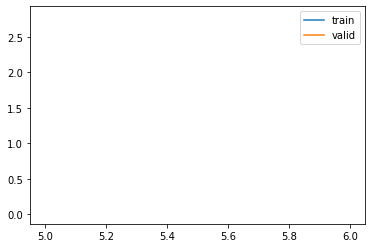

In [ ]:
m = Net()
data = DataLoaders(*[CustumData([make_data(100,bias = i)]*100, after_batch = NormalizeTS()) for i in [100,200]])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()    

(#4) [0,1235.869140625,2710.02880859375,'00:00']
(#4) [1,946.7556762695312,56322.80078125,'00:00']
(#4) [2,694.0796508789062,29347.955078125,'00:00']


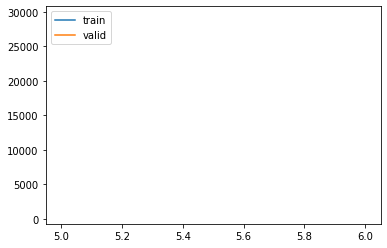

In [ ]:
m = Net()
data = DataLoaders(*[CustumData([make_data(100,bias = i)]*100) for i in [100,200]])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()   

You see the difference above

# Alternative

I would like to do the normalization inside the model but this gives different problems. Any ideas?

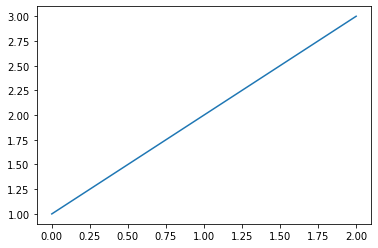

In [ ]:
class tensorT(torch.Tensor):
    def show(self,ctx=None):
        if ctx is None:
            f, ctx = plt.subplots()
        ctx.plot(self)
        
a = tensorT([1,2,3])
a.show()

(#4) [0,3909.198974609375,834.8953857421875,'00:00']
(#4) [1,2315.303466796875,82.82062530517578,'00:00']
(#4) [2,1505.5465087890625,121.20492553710938,'00:00']


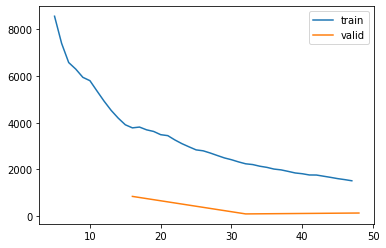

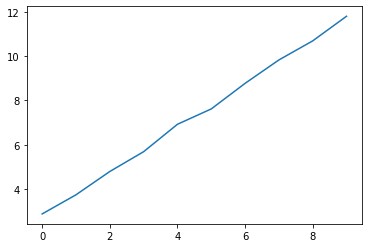

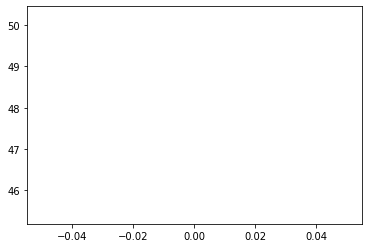

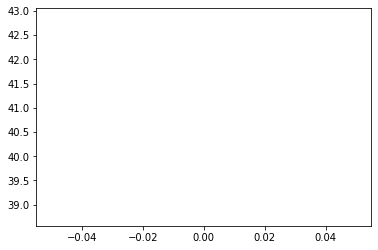

In [ ]:
m = Net()
data = DataLoaders(*[TfmdDL(make_data(1000, norm = False)) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3, .5)
learn.recorder.plot_loss()       
learn.show_results(max_n=1)

In [ ]:
m = Net(norm = True)
data = DataLoaders(*[TfmdDL(make_data(norm = False)) for _ in range(2)])
learn = Learner(data, m, F.mse_loss)

learn.fit(3)
learn.recorder.plot_loss()         
learn.show_results(max_n=1)

(#3) [0,1712.11279296875,'00:00']


/home/tako/dev/env37/lib/python3.7/site-packages/fastai2/learner.py:256: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  self.loss = self.loss_func(self.pred, *self.yb); self('after_loss')


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn